# Replication of NetSurfP 2.0 with pyTorch

The purpose of this notebook is to replicate the current version of NetSurfP 2.0

**Load libraries**

The different libraries are initialized and pytorch is either configured to use the CPU or an available GPU.

In [1]:
import pylab
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch_lr_finder import LRFinder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

# debugging
import pdb

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla V100-PCIE-16GB


## 1. Preparation of the data

Each dataset is compressed as a numpy zip and the dimensions of the dataset are as following: 

**[sequence, position, label]**

The labels are as following in the data (shown by index):
- [0:20] Amino Acids (sparse encoding) (Unknown residues are stored as an all-zero vector)
- [20:50] hmm profile
- [50] Seq mask (1 = seq, 0 = empty)
- [51] Disordered mask (0 = disordered, 1 = ordered)
- [52] Evaluation mask (For CB513 dataset, 1 = eval, 0 = ignore)
- [53] ASA (isolated)
- [54] ASA (complexed)
- [55] RSA (isolated)
- [56] RSA (complexed)
- [57:65] Q8 GHIBESTC (Q8 -> Q3: HHHEECCC)
- [65:67] Phi+Psi
- [67] ASA_max

### Loading the datasets

In [2]:
train_hhblits = np.load("../../data/nsp2/training_data/Train_HHblits_small.npz")
#CB513_hhblits = np.load("../../data/nsp2/training_data/CB513_HHblits.npz")
#TS115_hhblits = np.load("../../data/nsp2/training_data/TS115_HHblits.npz")
CASP12_hhblits = np.load("../../data/nsp2/training_data/CASP12_HHblits.npz")

#np.savez_compressed("../../data/nsp2/training_data/Train_HHblits_small.npz", data=train_hhblits['data'][:2500, :, :])

#train_mmseqs = np.load("../../data/nsp2/training_data/Train_MMseqs.npz")
#CB513_mmseqs = np.load("../../data/nsp2/training_data/CB513_MMseqs.npz")
#TS115_mmseqs = np.load("../../data/nsp2/training_data/TS115_MMseqs.npz")
#CASP12_mmseqs = np.load("../../data/nsp2/training_data/CASP12_MMseqs.npz")

### Custom Data loader class

A data loader class is created to load the NSP data into a DataLoader object. The DataLoader is a pytorch object, thats used to feed the data as batches. Which will be usefull when training and evaluating the NSP model. The NSPData class divides the dataset into input data and target labels.

In [3]:
class NSPData(Dataset):
    def __init__(self, dataset, indices = False):
        """ Constructor
        Args:
            X (np.array): The array that contains the training data
            y (np.array): The array that contains the test data
        """
        if indices:
            self.data = torch.tensor(dataset['data'][indices, :, :50]).float()
            self.targets = torch.tensor(dataset['data'][indices, :, 50:68]).float()
        else:
            self.data = torch.tensor(dataset['data'][:, :, :50]).float()
            self.targets = torch.tensor(dataset['data'][:, :, 50:68]).float()

    def __getitem__(self, index):
        """ Returns train and test data at an index
        Args:
            index (int): Index at the array
        """
        X = self.data[index]
        y = self.targets[index]
        seq_len = len(X[y[:, 0] == 1])
        
        return X, y, seq_len
    
    def __len__(self):
        """Returns the length of the data"""
        return len(self.data)

It is important to have a training and validation set when training to evaluate the training performance. Therefore, a function that splits the dataset into training and evaluation is created for that purpose.

In [4]:
def split_dataset(batch_size, dataset, split=0.05):
    """ Splits the dataset into train and validation
    Args:
        batch_size (int): size of each batch
        dataset (np.array): dataset containing training data
        validation_fraction (float): the size of the validation set as a fraction
    """
    
    num_train = len(dataset['data'])
    train_indices = np.array(range(num_train))
    validation_indices = np.random.choice(train_indices, int(num_train*split), replace=False)
    
    train_indices = np.delete(train_indices, validation_indices)
    
    # subset the dataset
    train_idx, valid_idx = train_indices, validation_indices
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    training_set = DataLoader(NSPData(dataset), sampler=train_sampler, batch_size=batch_size)
    validation_set = DataLoader(NSPData(dataset), sampler=valid_sampler, batch_size=batch_size)
    
    return training_set, validation_set
    

Cross validation

In [5]:
def partitions(number, k):
    '''
    Distribution of the folds
    Args:
        number: amount of sequences
        k: folds number
    '''
    n_partitions = np.ones(k) * int(number/k)
    n_partitions[0:(number % k)] += 1
    return n_partitions

def get_indices(n_splits, sequences):
    '''
    Indices for the validation
    Args:
        n_splits: folds number
        sequences: length of the sequence
    '''
    fold_sizes = partitions(sequences, n_splits)
    indices = np.arange(sequences).astype(int)
    current = 0
    for fold_size in fold_sizes:
        start = current
        stop =  current + fold_size
        current = stop
        yield(indices[int(start):int(stop)])

def k_folds(n_splits, sequences):
    '''
    Generates folds for cross validation
    Args:
        n_splits: folds number
        sequences: amount of sequences
    '''
    indices = np.arange(sequences).astype(int)
    for val_idx in get_indices(n_splits, sequences):
        train_idx = np.setdiff1d(indices, val_idx)
        yield SubsetRandomSampler(train_idx), SubsetRandomSampler(val_idx)

**Instanciate data into the data loader class**

The training datasets are splitted into training and validation for training. Whereas the test sets are simply loaded, since they are independent datasets. The batch sizes is set to 15. The default training/validation split is 80/20.

In [6]:
batch_size = 15

In [7]:
# training and validation sets
#train_hhblits = DataLoader(NSPData(train_hhblits), batch_size=batch_size, shuffle=True) 
train_hhblits = split_dataset(batch_size, train_hhblits)
#train_mmseqs = DataLoader(NSPData(train_mmseqs), batch_size=batch_size) #split_dataset(batch_size, train_mmseqs)

# test sets
#CB513_hhblits = DataLoader(NSPData(CB513_hhblits), batch_size=batch_size)
#TS115_hhblits = DataLoader(NSPData(TS115_hhblits), batch_size=batch_size)
CASP12_hhblits = DataLoader(NSPData(CASP12_hhblits), batch_size=batch_size)

#CB513_mmseqs = DataLoader(NSPData(CB513_mmseqs), batch_size=batch_size)
#TS115_mmseqs = DataLoader(NSPData(TS115_mmseqs), batch_size=batch_size)
#CASP12_mmseqs = DataLoader(NSPData(CASP12_mmseqs), batch_size=batch_size)

## 2. The NSP Classifier

The input layer consists of one-hot encoded sequences (20 features amino acids) and a full HMM profile (20 features for amino acid profile, 7 features of state transition probabilities and 3 features for local alignment diversity) The input layer is followed by two layers of 1D CNN layers, that consist of 32 filters with a size of 129 and 257. Whereas the output of the last 1D CNN is concatenated with the initial input features. These residuals connections are used to achieve a better backpropagation without gradient degradation and a deeper network. The concatenated input+residuals is then applied to 2 bidirectional long  short-term memory (LSTM) layers with 1024 nodes, that outputs 2048 hidden neurons. The hidden neurons output is input to a fully connected (FC) layer to predict the 18 classes (RSA, SS8, SS3, φ, ψ, and disorder).

In [8]:
class NSP_Network(nn.Module):
    def __init__(self, init_channels, n_hidden):
        """ Constructor of the NSP network
        Args:
            init_channels (int): The size of the incoming feature vector
            n_hidden: (int) The amount of hidden neurons in the bidirectional lstm
        """
        super(NSP_Network, self).__init__()

        self.hidden_dim = n_hidden
        
        # residual block
        self.conv1 = nn.Sequential(*[
            nn.Conv1d(in_channels=init_channels, out_channels=32, kernel_size=129, padding=64),
            #nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            #nn.Dropout(p=0.5)
        ])

        self.conv2 = nn.Sequential(*[
            nn.Conv1d(in_channels=init_channels, out_channels=32, kernel_size=257, padding=128),
            #nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            #nn.Dropout(p=0.5)
        ])

        self.lstm = nn.LSTM(input_size=init_channels+64, hidden_size=n_hidden, \
                                num_layers=2, batch_first=True, bidirectional=True)

        # output tasks
        #self.ss8 = nn.Linear(in_features=n_hidden*2, out_features=8)
        #self.ss3 = nn.Linear(in_features=n_hidden*2, out_features=3)
        #self.disorder = nn.Linear(in_features=n_hidden*2, out_features=2)
        self.rsa = nn.Linear(in_features=n_hidden*2, out_features=1)
        #self.phi = nn.Linear(in_features=n_hidden*2, out_features=2)
        #self.psi = nn.Linear(in_features=n_hidden*2, out_features=2)
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        n_layer = 2
        
        h, c = (Variable(torch.zeros(n_layer * 2, batch_size, self.hidden_dim).cuda()),
                Variable(torch.zeros(n_layer * 2, batch_size, self.hidden_dim).cuda()))
        
        return (h, c)
        
    def forward(self, x, lengths):
        """ Forwarding of the classifier input
        Args:
            x (torch.tensor): input data
        """
        # Get the sizes of the inputs
        b, l, _ = x.size()
        
        # calculate the residuals
        x = x.permute(0,2,1)
        r1 = self.conv1(x)
        r2 = self.conv2(x)
                
        # concatenate channels from residuals and input
        x = torch.cat([x, r1, r2], dim=1)
        
        # calculate double layer bidirectional lstm
        x = x.permute(0,2,1)
        
        self.hidden = self.init_hidden(b)
    
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x, self.hidden = self.lstm(x, self.hidden)
        x, _ = pad_packed_sequence(x, batch_first=True, total_length=l)
    
        # hidden neurons to classes
        #ss8 = self.ss8(x)
        #ss3 = self.ss3(x)
        #disorder = self.disorder(x)
        rsa = self.rsa(x)
        #phi = self.phi(x)
        #psi = self.psi(x)

        return [rsa] #[ss8, ss3, disorder, rsa, phi, psi]

## 3. Loss function

To train the model, loss functions are required. The tasks SS8, SS3 and disorder uses cross entropy loss function and RSA, φ and ψ use mean squared error loss.

Weights were adjusted so each loss contribution was approximately equal by using homoscedastic uncertainty and optimizing the log variances for each prediction. (https://arxiv.org/abs/1705.07115)

In the forwarding of the MultiTaskLoss, filters are used to remove extrapolated zeros or disordered regions from the calculated losses.

The indexes for the labels are described in the data preparation section.

In [9]:
class MultiTaskLoss(nn.Module):
    """ Weighs multiple loss functions by considering the 
        homoscedastic uncertainty of each task """
    
    def __init__(self):
        super(MultiTaskLoss, self).__init__()
        
        #self.log_vars = nn.Parameter(torch.zeros(6))

    def forward(self, outputs, labels):
        """ Forwarding of the multitaskloss input
        Args:
            outputs (torch.tensor): output data from model
            labels (torch.tensor): corresponding labels for the output
        """
         
        # filters
        zero_mask = (labels[:, :, 0] == 0)
        disorder_mask = (labels[:, :, 1] == 0)
        
        # apply the SS8 loss
        #SS8_labels = torch.argmax(labels[:, :, 7:15], dim=2)
        #SS8_inputs = outputs[0].permute(0, 2, 1)
        #SS8_loss = nn.CrossEntropyLoss(reduction="none")(SS8_inputs, SS8_labels)
        
        #SS8_loss = SS8_loss[zero_mask | disorder_mask].sum()
        
        # apply the SS3 loss
        #SS3_mask = torch.tensor([0,0,0,1,1,2,2,2], device=device)

        #SS3_labels = torch.max(labels[:, :, 7:15] * SS3_mask, dim=2)[0].long()
        #SS3_inputs = outputs[1].permute(0, 2, 1)
        #SS3_loss = nn.CrossEntropyLoss(reduction="none")(SS3_inputs, SS3_labels)
        
        #SS3_loss = SS3_loss[zero_mask | disorder_mask].sum()

        # apply the disorder loss
        #disorder_labels = labels[:, :, 1].long()
        #disorder_inputs = outputs[2].permute(0, 2, 1)
        #disorder_loss = nn.CrossEntropyLoss(reduction="none")(disorder_inputs, disorder_labels)
        
        #disorder_loss = disorder_loss[zero_mask].sum()

        # apply RSA loss
        rsa_labels = labels[:, :, 5]
        rsa_inputs = outputs[0].squeeze(2)
        
        rsa_loss = nn.MSELoss(reduction="none")(rsa_inputs, rsa_labels)
        
        with torch.no_grad():
            rsa_loss[zero_mask & disorder_mask] = 0
            
        rsa_loss = rsa_loss.sum()

        # apply phi loss
        #phi_labels = labels[:, :, 15].unsqueeze(2)
        #phi_inputs = outputs[4]
         
        #phi_loss = nn.MSELoss(reduction="none")(phi_inputs, \
        #                torch.cat((torch.sin(dihedral_to_radians(phi_labels)), torch.cos(dihedral_to_radians(phi_labels))), dim=2))
        
        #phi_loss = phi_loss[zero_mask].sum()
        
        # apply psi loss
        #psi_labels = labels[:, :, 16].unsqueeze(2)
        #psi_inputs = outputs[5]
        
        #psi_loss = nn.MSELoss(reduction="none")(psi_inputs, \
        #                torch.cat((torch.sin(dihedral_to_radians(psi_labels)), torch.cos(dihedral_to_radians(psi_labels))), dim=2))
        
        #psi_loss = psi_loss[zero_mask].sum()
        
        # weighted losses
        #loss = torch.stack([SS8_loss, SS3_loss, disorder_loss, rsa_loss, phi_loss, psi_loss])
        
        #loss = torch.exp(-self.log_vars) * loss + self.log_vars
        
        return rsa_loss #loss.mean()    

### Utils

The model trains phi and psi into each their vector that will contain calculated cos and sin values from the angle. Pytorch works with radians, so these helper functions helps converting dihedral angle values into radians and cos and sin radian values back to a dihedral angle.

In [10]:
def dihedral_to_radians(angle):
    """ Converts angles to radians
    Args:
        angles (1D Tensor): vector with angle values
    """
    return angle*np.pi/180
    
def arctan_dihedral(sin, cos):
    """ Converts sin and cos back to diheral angles
    Args:
        sin (1D Tensor): vector with sin values 
        cos (1D Tensor): vector with cos values
    """
    result = torch.where(cos >= 0, torch.arctan(sin/cos), torch.arctan(sin/cos)+np.pi)
    result = torch.where((sin <= 0) & (cos <= 0), result-np.pi*2, result)
    
    return result*180/np.pi

## 5. Early stopping

In [11]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 5. Training

Instanciating the model, criterion and optimizer

In [12]:
def init_model(initial_channels, hidden_neurons, learning_rate, weight_decay=0):
    """ Initializes a model, criterion and optimizer 
    Args:
        initial_channels (int): amount of initial inputs for the model
        hidden_neurons (int): amount of hidden neurons in the model
    """
    
    nsp_net = NSP_Network(initial_channels, hidden_neurons)
    criterion = MultiTaskLoss()

    # enable cuda on model and criterion if possible
    if device.type != "cpu":
        nsp_net.cuda(device)
        criterion.cuda(device)

    # optimizer for model and criterion
    optimizer = optim.Adam(nsp_net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    return nsp_net, criterion, optimizer

In [13]:
epochs = 50
initial_channels = 50
hidden_neurons = 64 #1024

nsp_hhblits = init_model(initial_channels, hidden_neurons, learning_rate=1e-3, weight_decay=0)
#nsp_mmseqs = init_model(initial_channels, hidden_neurons)

The model is trained by iterating through the training dataset for an amount of epochs. The model is trained using backpropagation using the multiple task loss.

In [14]:
def training(epochs, model, criterion, optimizer, dataset):
    # iterate over the dataset multiple times
    training_loss = []
    validation_loss = []

    train, validation = dataset
    
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train), epochs=epochs)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=5, verbose=True)
    
    for epoch in range(epochs):
        print('Epoch:', epoch + 1,' of ', epochs)

        # training of the model 
        running_loss = 0.0
        for i, data in enumerate(train, 0):
            inputs, labels, lengths = data
            # move data tensors to GPU if possible
            inputs, labels = inputs.to(device), labels.to(device)                         
            # zero the parameter gradients
            
            outputs = model(inputs, lengths)
            
            optimizer.zero_grad()
            # backpropagation by custom criterion
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        training_loss.append(running_loss / len(train))
        print("Training loss: ", round(training_loss[epoch], 2))

        #validation of the model
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(validation, 0):
                inputs, labels, lengths = data
                # move data tensors to GPU if possible
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs, lengths)

                loss = criterion(outputs, labels)

                running_loss += loss.item()

        validation_loss.append(running_loss / len(validation))
        print("Validation loss: ", round(validation_loss[epoch], 2))
        
        early_stopping(validation_loss[epoch], model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    print('Finished Training')
    
    return training_loss, validation_loss

The training loss and validation loss are visualized to evaluate the training performance.

In [15]:
def plot_loss(training_loss, validation_loss, title):
    pylab.plot(training_loss)
    pylab.plot(validation_loss)
    pylab.xlabel('Epochs')
    pylab.ylabel('Loss [sum]')
    pylab.legend(('Training loss', 'Validation loss'))
    pylab.title(title)
    pylab.show()

Epoch: 1  of  50
Training loss:  266.16
Validation loss:  199.73
Validation loss decreased (inf --> 199.734006).  Saving model ...
Epoch: 2  of  50
Training loss:  203.92
Validation loss:  200.15
EarlyStopping counter: 1 out of 5
Epoch: 3  of  50
Training loss:  196.19
Validation loss:  180.24
Validation loss decreased (199.734006 --> 180.241292).  Saving model ...
Epoch: 4  of  50
Training loss:  192.29
Validation loss:  183.04
EarlyStopping counter: 1 out of 5
Epoch: 5  of  50
Training loss:  187.59
Validation loss:  182.68
EarlyStopping counter: 2 out of 5
Epoch: 6  of  50
Training loss:  179.99
Validation loss:  167.35
Validation loss decreased (180.241292 --> 167.352616).  Saving model ...
Epoch: 7  of  50
Training loss:  170.78
Validation loss:  172.15
EarlyStopping counter: 1 out of 5
Epoch: 8  of  50
Training loss:  168.53
Validation loss:  169.32
EarlyStopping counter: 2 out of 5
Epoch: 9  of  50
Training loss:  169.2
Validation loss:  162.87
Validation loss decreased (167.352

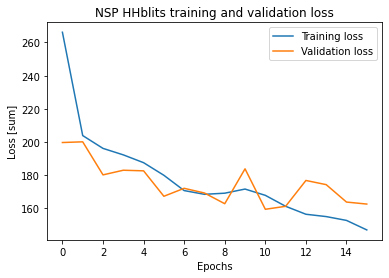

In [16]:
training_loss, evaluation_loss = training(epochs, nsp_hhblits[0], nsp_hhblits[1], nsp_hhblits[2], train_hhblits)

plot_loss(training_loss, evaluation_loss, "NSP HHblits training and validation loss")

#training_loss, evaluation_loss = training(epochs, nsp_mmseqs[0], nsp_mmseqs[1], nsp_mmseqs[2], train_mmseqs)
#plot_loss(training_loss, evaluation_loss, "NSP MMseqs training and validation loss")

## 5. Evaluation

Evaluation functions are created to evaluate the models performance.

In [17]:
def fpr(pred, labels):
    """ False positive rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tn = sum((pred == 0) & (labels == 0))
    
    return (fp/(fp+tn)).item()

def fnr(pred, labels):
    """ False negative rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fn = sum((pred == 0) & (labels == 1))
    tp = sum((pred == 1) & (labels == 1))
    
    return (fn/(fn+tp)).item()

def mcc(pred, labels):
    """ Mathews correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tp = sum((pred == 1) & (labels == 1))
    fn = sum((pred == 0) & (labels == 1))
    tn = sum((pred == 0) & (labels == 0))
    
    return ((tp*tn-fp*fn)/torch.sqrt(((tp+fp)*(fn+tn)*(tp+fn)*(fp+tn)).float())).item()

def pcc(pred, labels):
    """ Pearson correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    x = pred - torch.mean(pred)
    y = labels - torch.mean(labels)
    
    return (torch.sum(x * y) / (torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2)))).item()

def mae(pred, labels):
    """ Mean absolute error
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    
    return (sum(torch.min(torch.cat((abs(labels-pred).unsqueeze(1), abs(360-labels+pred).unsqueeze(1)), dim=1), dim=1)[0])/len(labels)).item()
    
def accuracy(pred, labels):
    """ Accuracy coefficient
    Args:
        inputs (1D Tensor): vector with predicted integer values
        labels (1D Tensor): vector with correct integer values
    """
    
    return (sum((pred == labels)) / len(labels)).item()

Seperate datasets are used to evaluate the model. Here is each class evaluated and the prediction benchmarks for the trained model are found.

In [18]:
def evaluation(model, dataset):
    # store evaluation results
    results = {
        "SS8": 0,
        "SS3": 0,
        "disorder_mcc": 0,
        "disorder_fnr": 0,
        "RSA": 0,
        "ASA": 0,
        "psi": 0,
        "phi": 0,
    }
    
    rsa_labels = torch.tensor([]).to(device)
    rsa_pred = torch.tensor([]).to(device)
    
    # iterate through the evaluation dataset
    with torch.no_grad():
        for data in dataset:
            # move data tensors to GPU if possible
            inputs, labels, lengths = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            predictions = model(inputs, lengths) # predict values

            # Use only sequences from seq mask and remove extrapolated zeroes
            #predictions = [pred[(labels[:, :, 0] == 1) & (labels[:, :, 1] == 1)] for pred in predictions]
            #labels = labels[(labels[:, :, 0] == 1) & (labels[:, :, 1] == 1)]

            # filters
            zero_mask = (labels[:, :, 0] == 1)
            disorder_mask = (labels[:, :, 1] == 1)

            # calculate the SS8 accuracy
            #SS8_labels = torch.argmax(labels[:, 7:15], dim=1).flatten()
            #SS8_pred = torch.argmax(predictions[0], dim=1).flatten()

            #results["SS8"] += accuracy(SS8_pred, SS8_labels)

            # calculate the SS3 accuracy
            #SS3_mask = torch.tensor([0,0,0,1,1,2,2,2], device=device)

            #SS3_labels = torch.max(labels[:, 7:15] * SS3_mask, dim=1)[0].long().flatten()
            #SS3_pred = torch.argmax(predictions[1], dim=1).flatten()

            #results["SS3"] += accuracy(SS3_pred, SS3_labels)

            # calculate the FPR of disorder
            #disorder_labels = labels[:, 1].flatten()
            #disorder_pred = torch.argmax(predictions[2], dim=1).flatten()

            #results["disorder_mcc"] += mcc(disorder_pred, disorder_labels)
            #results["disorder_fnr"] += fnr(disorder_pred, disorder_labels)

            # calculate the RSA
            #rsa_labels = labels[:, 6].flatten()
            #rsa_pred = predictions[0].flatten()
            
            rsa_pred = torch.cat([rsa_pred, predictions[0][zero_mask & disorder_mask].flatten()])
            rsa_labels = torch.cat([rsa_labels, labels[:, :, 5][zero_mask & disorder_mask].flatten()])

            #results['RSA'] += pcc(rsa_pred, rsa_labels)

            # calculate the ASA
            #asa_labels = labels[:, 4].flatten()
            #asa_max = labels[:, 17].flatten()

            #results['ASA'] += pcc(asa_max * rsa_pred, asa_labels)

            # calculate the psi
            #phi_labels = labels[:, 15].flatten()
            #phi_pred = arctan_dihedral(predictions[4][:, 0], predictions[4][:, 1]).flatten()

            #results['phi'] += mae(phi_pred, phi_labels)

            # calculate the psi
            #psi_labels = labels[:, 16].flatten()
            #psi_pred = arctan_dihedral(predictions[5][:, 0], predictions[5][:, 1]).flatten()

            #results['psi'] += mae(psi_pred, psi_labels)

        # average prediction results 
        #for method, _ in results.items():
            #results[method] /= len(dataset)
            
    results['RSA'] = pcc(rsa_pred, rsa_labels)

    print("RSA (PCC): {}".format(round(results["RSA"], 3)))
    print("ASA (PCC): {}".format(round(results["ASA"], 2)))
    print("SS8 [Q8]: {}".format(round(results["SS8"], 2)))
    print("SS3 [Q3]: {}".format(round(results["SS3"], 2)))
    print("Disorder (MCC): {}".format(round(results["disorder_mcc"], 2)))
    print("Disorder (FNR): {}".format(round(results["disorder_fnr"], 3)))
    print("Phi (MAE): {}".format(round(results["phi"], 2)))
    print("Psi (MAE): {}".format(round(results["psi"], 2)))

The models are evaluated

In [19]:
print("Evaluation HHblits...")

#print("\nCB513")
#evaluation(nsp_hhblits[0], CB513_hhblits)
#print("\nTS115")
#evaluation(nsp_hhblits[0], TS115_hhblits)
print("\nCASP12")
evaluation(nsp_hhblits[0], CASP12_hhblits)

#print("\nEvaluation MMseqs...")

#print("\nCB513")
#evaluation(nsp_mmseqs[0], CB513_hhblits)
#print("\nTS115")
#evaluation(nsp_mmseqs[0], TS115_hhblits)
#print("\nCASP12")
#evaluation(nsp_mmseqs[0], CASP12_hhblits)

Evaluation HHblits...

CASP12
RSA (PCC): 0.569
ASA (PCC): 0
SS8 [Q8]: 0
SS3 [Q3]: 0
Disorder (MCC): 0
Disorder (FNR): 0
Phi (MAE): 0
Psi (MAE): 0
